In [1]:
import numpy as np
import pandas as pd
from math import exp
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
def read_training_data():
    df = pd.read_csv('train.dat', delimiter='\t', names=["antibiofilm","peptides"])
    return df

In [3]:
def read_testing_data():
    df = pd.read_csv('test.dat', delimiter='\t', names=["peptides"])
    return df

In [4]:
def kmer(seq, size):
    return [seq[x:x+size].lower() for x in range(0, len(seq) - size + 1)] #stride - size - int(size/2)

In [5]:
def kmers(seq, k=2):
    features = []
    for i in range(1,k):
        features.extend(kmer(seq, i))
    return features

In [6]:
def generate_features(X):
    X_features = []
    for x in X:
        X_features.append(kmers(x, 4))

    for item in range(len(X_features)):
        X_features[item] = ' '.join(X_features[item])
    return X_features

In [7]:
def generate_feature_vector(X):
    features = set()
    for x in X:
        features.update(x.split()) 
    features = list(sorted(features))
    return features

In [8]:
def generate_vector(X, features):
    X_vector = np.zeros((len(X),len(features)))
    for i,x in enumerate(X):
        count = Counter(x.split())
        for c, cnt  in count.items(): 
            if c in features:
                X_vector[i][features.index(c)] = cnt
        X_vector[i] = X_vector[i]/np.max(X_vector[i])
    return X_vector

In [9]:
def oversample(X, Y):
    oversample = RandomOverSampler(sampling_strategy=0.2, random_state = 65)
    X_over, Y_over = oversample.fit_resample(X, Y)
    return X_over, Y_over

In [10]:
def relu(x):
    return np.maximum(0.0, x)

def relu_derivative(x):
    return np.where(x>0, 1, 0)

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(s_x):
    return np.multiply(s_x, np.subtract(1.0, s_x)) 

In [12]:
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def tanh_derivative(x):
    return 1 - x ** 2

In [13]:
def forward_prop(X, W1, W2, W3, b1, b2, b3):
    
    z1 = relu(np.dot(X,W1) + b1)
    z2 = relu(np.dot(z1, W2) + b2)
    y_pred = sigmoid(np.dot(z2, W3) + b3)
    
    return z1, z2, y_pred

In [14]:
BATCH_SIZE=128
NUM_HN1=600
NUM_HN2=100
ALPHA=0.0001
LR = 0.001

In [15]:
def calculate_mse_loss(y_pred, y, W1, W2, W3):
    return np.sum(((y-y_pred) ** 2) + ALPHA * (np.linalg.norm(W1)+np.linalg.norm(W2)+np.linalg.norm(W3)))

In [16]:
def backward_prop(X, Y, y_pred, Z1, Z2, W1, W2, W3, b1, b2, b3):
    delta_w3 = sigmoid_derivative(y_pred) * (Y-y_pred) #number of instances * number of output neurons
    delta_w2 = relu_derivative(Z2) * np.dot(delta_w3, W3.T)
    delta_w1 = relu_derivative(Z1) * np.dot(delta_w2, W2.T)
    
    W3 = W3 + (LR * (np.dot(Z2.T, delta_w3)))
    W3 = W3 - (LR * ALPHA * np.sign(W3))
    b3 = b3 + (LR * np.dot(np.ones((1,delta_w3.shape[0])), delta_w3))
    W2 = W2 + (LR * (np.dot(Z1.T, delta_w2)))
    W2 = W2 - (LR * ALPHA * np.sign(W2))
    b2 = b2 + (LR * np.dot(np.ones((1,delta_w2.shape[0])), delta_w2))
    W1 = W1 + (LR * (np.dot(X.T, delta_w1)))
    W1 = W1 - (LR * ALPHA * np.sign(W1))
    b1 = b1 + (LR * np.dot(np.ones((1,delta_w1.shape[0])), delta_w1))
    return W1, W2, W3, b1, b2, b3          

In [17]:
def train_ANN(X_train, Y_train, X_test, Y_test, features, n_epochs):
    b1 = np.zeros((1,NUM_HN1))
    b2 = np.zeros((1,NUM_HN2))
    b3 = np.zeros((1))
    R = np.random.RandomState(1997)
    W1 = R.normal(0, (2/X_train.shape[1]), (len(features), NUM_HN1)) #number of input neurons * number of output neurons
    W2 = R.normal(0, (2/NUM_HN1), (NUM_HN1, NUM_HN2))
    W3 = R.normal(0, (2/NUM_HN2+1), (NUM_HN2, 1))
    
    Y_train = Y_train[np.newaxis].T
    Y_test = Y_test[np.newaxis].T
    training_loss = []
    validation_loss = []
    training_mcc = []
    validation_mcc = []
    for epoch in range(n_epochs):
        for i in range(0, len(X_train), BATCH_SIZE):
            Xbatch = X_train[i:i+BATCH_SIZE]
            Ybatch = Y_train[i:i+BATCH_SIZE]
            Z1, Z2, y_pred = forward_prop(Xbatch, W1, W2, W3, b1, b2, b3) #number of instances * number of output
            W1, W2, W3, b1, b2, b3 = backward_prop(Xbatch, Ybatch, y_pred, Z1, Z2, W1, W2, W3, b1, b2, b3)
        
        Z1, Z2, y_pred = forward_prop(X_train, W1, W2, W3, b1, b2, b3)
        loss = calculate_mse_loss(y_pred, Y_train, W1, W2, W3)
        training_loss.append(loss)
        y_pred = np.where(y_pred < 0.6, 0, 1)
        training_mcc.append(matthews_corrcoef(y_pred, Y_train))
        print(f'Finished epoch {epoch}, latest loss {loss}, MCC {training_mcc[-1]}')
        
        Z1, Z2, y_pred = forward_prop(X_test, W1, W2, W3, b1, b2, b3)
        loss = calculate_mse_loss(y_pred, Y_test, W1, W2, W3)
        validation_loss.append(loss)
        if epoch%20==0:
            plt.scatter(y_pred, y_test)
            plt.show()
        y_pred = np.where(y_pred < 0.6, 0, 1)
        validation_mcc.append(matthews_corrcoef(y_pred, Y_test)) 
        print(f'Validation MCC {validation_mcc[-1]}, Validation loss {validation_loss[-1]}')
        
    return W1, W2, W3, b1, b2, b3, training_loss, training_mcc, validation_loss, validation_mcc
        

In [18]:
def plot_loss_graph(training_loss, validation_loss, n_epochs):
    epochs = range(1,n_epochs + 1)
    plt.plot(epochs, training_loss, label='Training loss')
    plt.plot(epochs, validation_loss, label='Validation loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend(loc='best')
    plt.show()

In [19]:
def plot_mcc_graph(training_mcc, validation_mcc, n_epochs):
    epochs = range(1,n_epochs + 1)
    plt.plot(epochs, training_mcc, label='Training MCC')
    plt.plot(epochs, validation_mcc, label='Validation MCC')

    plt.title('Training and Validation MCC')
    plt.xlabel('Epochs')
    plt.ylabel('MCCs')

    plt.legend(loc='best')
    plt.show()

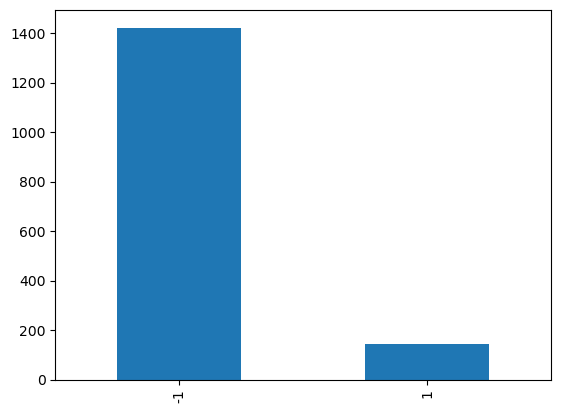

In [20]:
df = read_training_data() 
df['antibiofilm'].value_counts().plot.bar() 
X, Y = df['peptides'].to_numpy(), df['antibiofilm'].to_numpy()

In [21]:
NUM_EPOCHS = 200

Finished epoch 0, latest loss 200.57993073236253, MCC 0.0


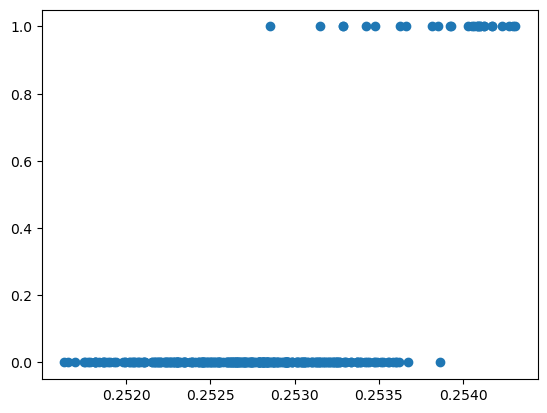

Validation MCC 0.0, Validation loss 34.19550497913736
Finished epoch 1, latest loss 195.5731002512167, MCC 0.0
Validation MCC 0.0, Validation loss 31.971632561763993
Finished epoch 2, latest loss 194.7118028357153, MCC 0.0
Validation MCC 0.0, Validation loss 31.685982084332256
Finished epoch 3, latest loss 194.2895378699241, MCC 0.0
Validation MCC 0.0, Validation loss 31.672340372177516
Finished epoch 4, latest loss 193.85714005799758, MCC 0.0
Validation MCC 0.0, Validation loss 31.718244008595136
Finished epoch 5, latest loss 193.30685677393262, MCC 0.0
Validation MCC 0.0, Validation loss 31.793055183157485
Finished epoch 6, latest loss 192.5826873325417, MCC 0.0
Validation MCC 0.0, Validation loss 31.901096807780213
Finished epoch 7, latest loss 191.6314178911855, MCC 0.0
Validation MCC 0.0, Validation loss 32.05955887941632
Finished epoch 8, latest loss 190.39894386003448, MCC 0.0
Validation MCC 0.0, Validation loss 32.29660086948388
Finished epoch 9, latest loss 188.83629713202447,

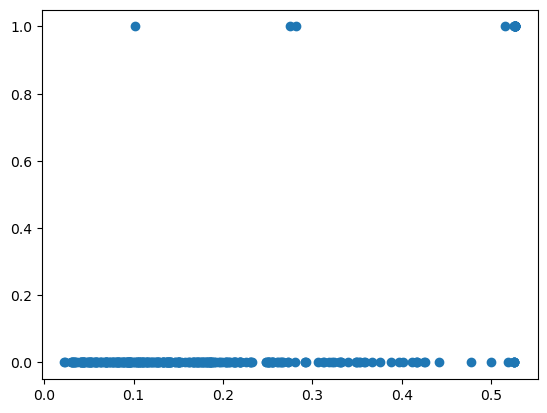

Validation MCC 0.0, Validation loss 19.559354337995813
Finished epoch 21, latest loss 99.84832964089102, MCC 0.0
Validation MCC 0.0, Validation loss 18.57823350255721
Finished epoch 22, latest loss 96.17151490060888, MCC 0.0
Validation MCC 0.0, Validation loss 18.00460624803307
Finished epoch 23, latest loss 92.79620278240247, MCC 0.0
Validation MCC 0.0, Validation loss 17.462662596780802
Finished epoch 24, latest loss 88.46319670508939, MCC 0.0
Validation MCC 0.0, Validation loss 16.548494141233512
Finished epoch 25, latest loss 85.16098052191009, MCC 0.0
Validation MCC 0.0, Validation loss 15.949436592286883
Finished epoch 26, latest loss 82.07305454486541, MCC 0.0
Validation MCC 0.0, Validation loss 15.404940065553525
Finished epoch 27, latest loss 79.12526119570973, MCC 0.0
Validation MCC 0.0, Validation loss 14.86417739345453
Finished epoch 28, latest loss 76.00639607253956, MCC 0.0
Validation MCC 0.0, Validation loss 14.213197409055665
Finished epoch 29, latest loss 73.6046760631

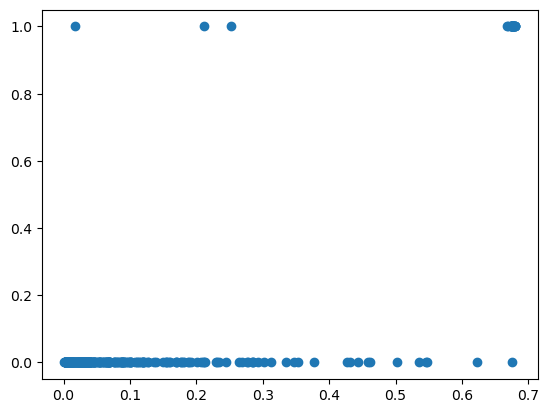

Validation MCC 0.9005468707320919, Validation loss 10.955249043777332
Finished epoch 41, latest loss 53.466137964747546, MCC 0.9110210725768948
Validation MCC 0.9005468707320919, Validation loss 10.844901657501904
Finished epoch 42, latest loss 52.14461311726605, MCC 0.9110210725768948
Validation MCC 0.9005468707320919, Validation loss 10.630130568402073
Finished epoch 43, latest loss 50.85067345708398, MCC 0.9110210725768948
Validation MCC 0.9005468707320919, Validation loss 10.412438348785072
Finished epoch 44, latest loss 49.62087119770355, MCC 0.9110210725768948
Validation MCC 0.9005468707320919, Validation loss 10.20842540701797
Finished epoch 45, latest loss 48.503335545553426, MCC 0.9110210725768948
Validation MCC 0.9005468707320919, Validation loss 10.036527940972949
Finished epoch 46, latest loss 47.42050126046583, MCC 0.9110210725768948
Validation MCC 0.9005468707320919, Validation loss 9.868052615199236
Finished epoch 47, latest loss 46.37083246907886, MCC 0.9220644207383119

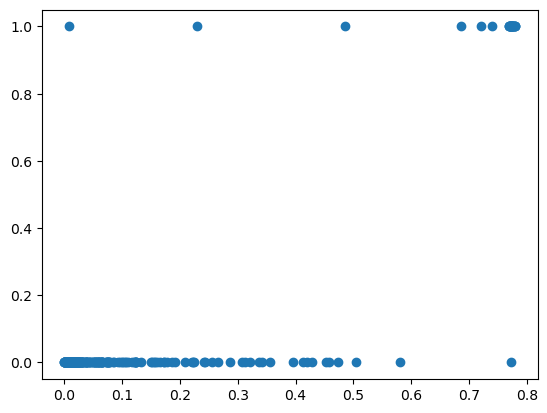

Validation MCC 0.9197229406712755, Validation loss 7.999715291307716
Finished epoch 61, latest loss 35.08386186164603, MCC 0.9385278664707436
Validation MCC 0.9197229406712755, Validation loss 7.897164546441767
Finished epoch 62, latest loss 34.48150312894358, MCC 0.9385278664707436
Validation MCC 0.9197229406712755, Validation loss 7.810203447766361
Finished epoch 63, latest loss 33.881924375628174, MCC 0.9385278664707436
Validation MCC 0.9197229406712755, Validation loss 7.719574302379445
Finished epoch 64, latest loss 33.30500588131209, MCC 0.9385278664707436
Validation MCC 0.9197229406712755, Validation loss 7.636054231716292
Finished epoch 65, latest loss 32.74301267935577, MCC 0.9438986622135361
Validation MCC 0.9197229406712755, Validation loss 7.556154707509115
Finished epoch 66, latest loss 32.21780321789776, MCC 0.9438986622135361
Validation MCC 0.9197229406712755, Validation loss 7.4917088672556496
Finished epoch 67, latest loss 31.707164048246522, MCC 0.9438986622135361
Val

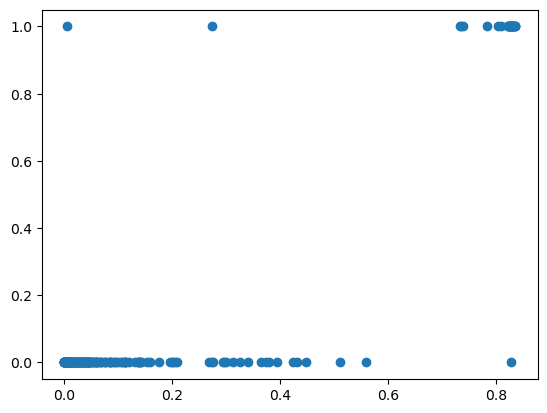

Validation MCC 0.9404075582722494, Validation loss 6.719943001073158
Finished epoch 81, latest loss 25.299746344336164, MCC 0.9654341075204025
Validation MCC 0.9404075582722494, Validation loss 6.680829630884259
Finished epoch 82, latest loss 24.919066822485732, MCC 0.9654341075204025
Validation MCC 0.9404075582722494, Validation loss 6.638671698672065
Finished epoch 83, latest loss 24.54267739333251, MCC 0.9654341075204025
Validation MCC 0.9404075582722494, Validation loss 6.595201221669119
Finished epoch 84, latest loss 24.17172648773928, MCC 0.9654341075204025
Validation MCC 0.9404075582722494, Validation loss 6.551802676596109
Finished epoch 85, latest loss 23.813828697038197, MCC 0.9654341075204025
Validation MCC 0.9404075582722494, Validation loss 6.513189490264655
Finished epoch 86, latest loss 23.444231335295186, MCC 0.9681255074942297
Validation MCC 0.9404075582722494, Validation loss 6.465261164737344
Finished epoch 87, latest loss 23.09772120069907, MCC 0.9681255074942297
Va

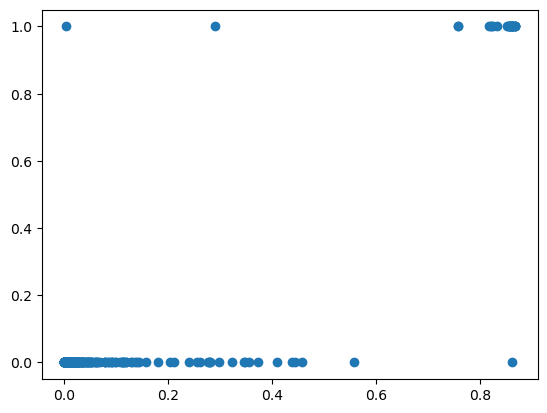

Validation MCC 0.9404075582722494, Validation loss 6.057909219470857
Finished epoch 101, latest loss 18.368559300618557, MCC 0.9708141534770857
Validation MCC 0.9404075582722494, Validation loss 6.030196404352234
Finished epoch 102, latest loss 18.06409144888444, MCC 0.9788639161369742
Validation MCC 0.9404075582722494, Validation loss 5.983265116908754
Finished epoch 103, latest loss 17.767083506326898, MCC 0.9788639161369742
Validation MCC 0.9404075582722494, Validation loss 5.931737723923307
Finished epoch 104, latest loss 17.485211628444983, MCC 0.9788639161369742
Validation MCC 0.9404075582722494, Validation loss 5.881178437126801
Finished epoch 105, latest loss 17.219484168953826, MCC 0.9788639161369742
Validation MCC 0.9404075582722494, Validation loss 5.8327479639409985
Finished epoch 106, latest loss 16.96500714406075, MCC 0.9788639161369742
Validation MCC 0.9404075582722494, Validation loss 5.784397279173027
Finished epoch 107, latest loss 16.730503778549934, MCC 0.9788639161

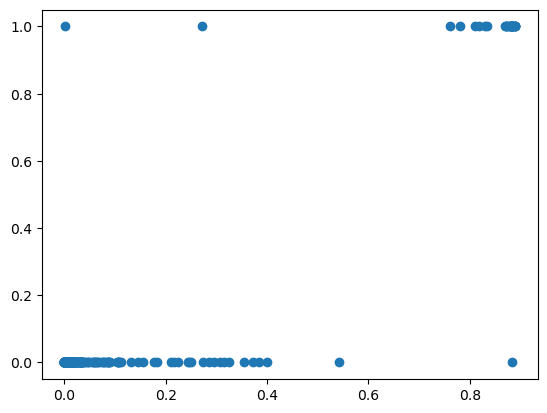

Validation MCC 0.9404075582722494, Validation loss 5.283752325044077
Finished epoch 121, latest loss 14.07712713664729, MCC 0.9788639161369742
Validation MCC 0.9404075582722494, Validation loss 5.253195374879597
Finished epoch 122, latest loss 13.932835613427212, MCC 0.9788639161369742
Validation MCC 0.9404075582722494, Validation loss 5.232316528542771
Finished epoch 123, latest loss 13.781749262986798, MCC 0.9788639161369742
Validation MCC 0.9404075582722494, Validation loss 5.204718842656513
Finished epoch 124, latest loss 13.644483114450862, MCC 0.9788639161369742
Validation MCC 0.9404075582722494, Validation loss 5.185144397127173
Finished epoch 125, latest loss 13.499050438157344, MCC 0.9788639161369742
Validation MCC 0.9404075582722494, Validation loss 5.157410671202365
Finished epoch 126, latest loss 13.371166628083559, MCC 0.9788639161369742
Validation MCC 0.9404075582722494, Validation loss 5.141568283889074
Finished epoch 127, latest loss 13.227454085674108, MCC 0.9788639161

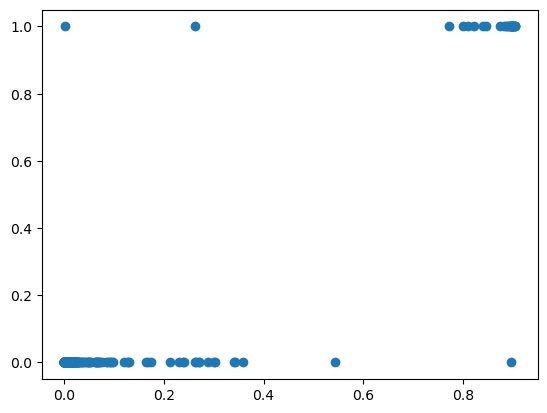

Validation MCC 0.9404075582722494, Validation loss 4.878280637486782
Finished epoch 141, latest loss 11.626355736939646, MCC 0.9841479371027306
Validation MCC 0.9404075582722494, Validation loss 4.86357887497374
Finished epoch 142, latest loss 11.522952231707517, MCC 0.9841479371027306
Validation MCC 0.9404075582722494, Validation loss 4.844428417907566
Finished epoch 143, latest loss 11.427730488135252, MCC 0.9841479371027306
Validation MCC 0.9404075582722494, Validation loss 4.830963165358543
Finished epoch 144, latest loss 11.33168231673175, MCC 0.9841479371027306
Validation MCC 0.9404075582722494, Validation loss 4.815747258913631
Finished epoch 145, latest loss 11.239445997640356, MCC 0.9841479371027306
Validation MCC 0.9404075582722494, Validation loss 4.802725067882683
Finished epoch 146, latest loss 11.145795808750513, MCC 0.9841479371027306
Validation MCC 0.9404075582722494, Validation loss 4.787186360018872
Finished epoch 147, latest loss 11.055175591756502, MCC 0.98414793710

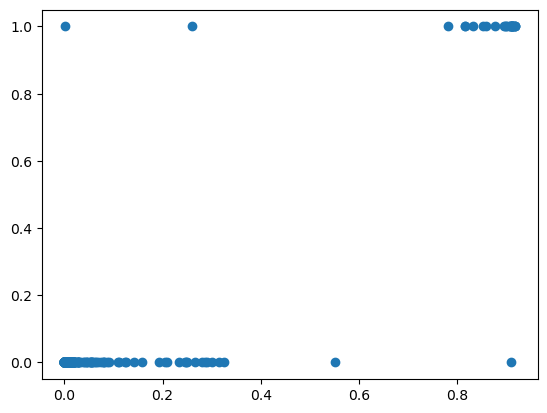

Validation MCC 0.9404075582722494, Validation loss 4.621410904005068
Finished epoch 161, latest loss 9.920135005581605, MCC 0.9894319580684872
Validation MCC 0.9404075582722494, Validation loss 4.609713872314298
Finished epoch 162, latest loss 9.849282307781378, MCC 0.9894319580684872
Validation MCC 0.9404075582722494, Validation loss 4.601591395041666
Finished epoch 163, latest loss 9.776680604290643, MCC 0.9894319580684872
Validation MCC 0.9404075582722494, Validation loss 4.5904445990518585
Finished epoch 164, latest loss 9.707596364538144, MCC 0.9894319580684872
Validation MCC 0.9404075582722494, Validation loss 4.581791718959577
Finished epoch 165, latest loss 9.637636943276878, MCC 0.9894319580684872
Validation MCC 0.9404075582722494, Validation loss 4.571002313096299
Finished epoch 166, latest loss 9.572938448889008, MCC 0.9894319580684872
Validation MCC 0.9404075582722494, Validation loss 4.564564444714692
Finished epoch 167, latest loss 9.50373871797209, MCC 0.9894319580684872

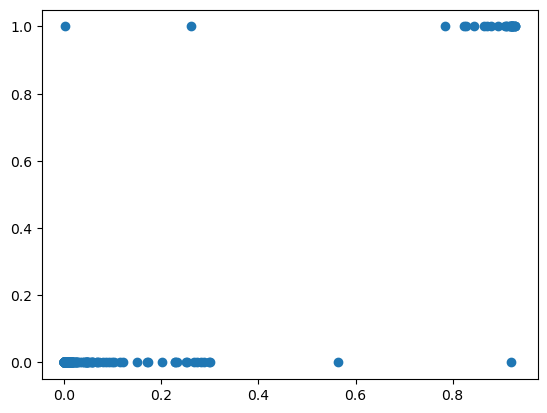

Validation MCC 0.9404075582722494, Validation loss 4.45315192264727
Finished epoch 181, latest loss 8.69968041950365, MCC 0.9894319580684872
Validation MCC 0.9404075582722494, Validation loss 4.44773957548389
Finished epoch 182, latest loss 8.647661757758963, MCC 0.9894319580684872
Validation MCC 0.9404075582722494, Validation loss 4.43899975365904
Finished epoch 183, latest loss 8.600706972951103, MCC 0.9894319580684872
Validation MCC 0.9404075582722494, Validation loss 4.435802876375416
Finished epoch 184, latest loss 8.550137440644164, MCC 0.9894319580684872
Validation MCC 0.9404075582722494, Validation loss 4.427076250140782
Finished epoch 185, latest loss 8.502669198909805, MCC 0.9894319580684872
Validation MCC 0.9404075582722494, Validation loss 4.421424867080789
Finished epoch 186, latest loss 8.456102882987128, MCC 0.9894319580684872
Validation MCC 0.9404075582722494, Validation loss 4.416085913959093
Finished epoch 187, latest loss 8.409491426471693, MCC 0.9894319580684872
Val

In [22]:
X_features = generate_features(X)
features = generate_feature_vector(X_features)
X_vector = generate_vector(X_features, features)
X_train, X_test, y_train, y_test = train_test_split(X_vector, 
                                                    Y, 
                                                    test_size = 0.20, 
                                          random_state=42, stratify=Y)

X_over, Y_over = oversample(X_train, y_train)

Y_over = np.where(Y_over<0, 0, 1)
y_test = np.where(y_test<0, 0, 1)

W1, W2, W3, b1, b2, b3, training_loss, training_mcc, validation_loss, validation_mcc = train_ANN(X_over, Y_over, X_test, y_test, features, NUM_EPOCHS)

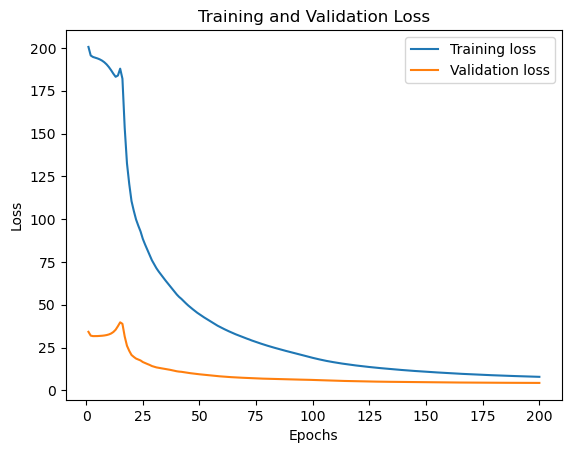

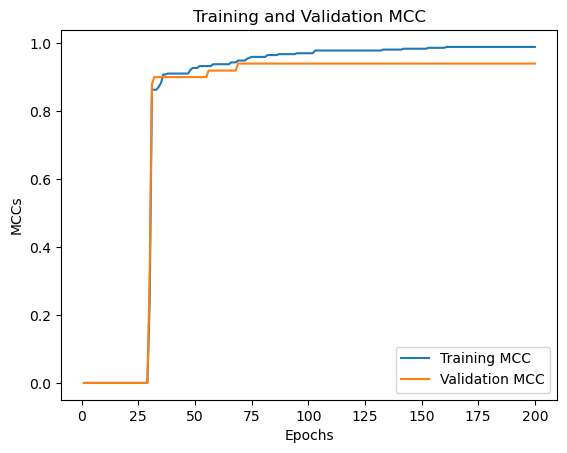

In [23]:
plot_loss_graph(training_loss, validation_loss, NUM_EPOCHS)
plot_mcc_graph(training_mcc, validation_mcc, NUM_EPOCHS)

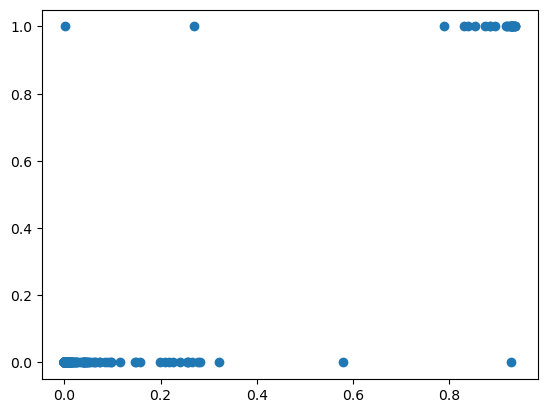

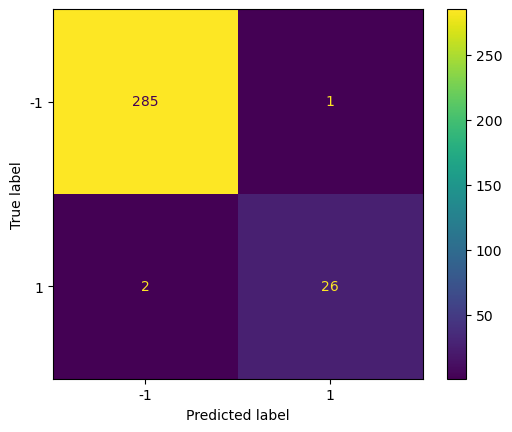

In [24]:
#Scatter Plot
Z1, Z2, y_pred = forward_prop(X_test, W1, W2, W3, b1, b2, b3) 
plt.scatter(y_pred, y_test)
plt.show()

#Confusion Matrix
y_pred = np.where(y_pred < 0.6, -1, 1)
y_test = np.where(y_test==0, -1, 1)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [27]:
X_t = read_testing_data()["peptides"].to_numpy()
X_features = generate_features(X_t)
X_vector = generate_vector(X_features, features)

Z1, Z2, y = forward_prop(X_vector, W1, W2, W3, b1, b2, b3) 
y = np.where(y < 0.6, -1, 1)
np.savetxt('test1.txt', y, delimiter='\n',fmt='%i')